# DSCI100 Notes 2

### Classification

**What is KNN:**

The k-nearest neighbors classification algorithm classifies new predictions based on it's k nearest neighbors. K is simply an integer (usually odd to avoid a 50/50 vote) that is pre-determined through testing to ensure the highest accuracy. The algorithm looks at the K nearest neighbours' classes and uses it to determine the class of the new observation. Each neighbor gets a vote based on its class. The class with the majority of votes is then picked as the class for the new observation.

**Advantages and Disadvantages of KNN:**

One advantage of k-nn classification is that it works well for both binary and multiple classes. Additionally, it does not require that the data is linear.

One disadvantage is that k-nn classification may become very slow for large data sets or if there are too many predictor variables as it requires high computation power. Additionally, k-nn classification requires a good distribution of classes in the training data to perform accurately.

**Distance Between Points:**

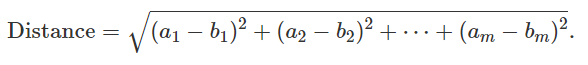

**Splitting Data:**

Shuffles data and then splits them so that classes are distruibuted evenly.

cancer_split <- initial_split(cancer, prop = 0.75, strata = Class)  
cancer_train <- training(cancer_split)  
cancer_test <- testing(cancer_split)

**Recipe:**

cancer_recipe <- recipe(Class ~ Smoothness + Concavity, data = cancer_train) |>  
  step_scale(all_predictors()) |>  
  step_center(all_predictors())

**Cross Validation:**

Splits data into 1 validation set and 4 training sets (iterates through such that each set becomes a validation set once).

cancer_vfold <- vfold_cv(cancer_train, v = 10, strata = Class)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>  
  set_engine("kknn") |>  
  set_mode("classification")  
  
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>  
  add_recipe(cancer_recipe) |>  
  add_model(knn_spec) |>  
  tune_grid(resamples = cancer_vfold, grid = k_vals) |>  
  collect_metrics()  

accuracies <- knn_results |>  
  filter(.metric == "accuracy")

accuracies

**Plotting K-Values:**  

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +  
  geom_point() +  
  geom_line() +  
  labs(x = "Neighbors", y = "Accuracy Estimate") +   
  theme(text = element_text(size = 12))  

accuracy_vs_k  

**Prediction:**  
cancer_test_predictions <- predict(knn_fit, cancer_test) |>  
  bind_cols(cancer_test)  

cancer_test_predictions  
cancer_test_predictions |>  
  metrics(truth = Class, estimate = .pred_class) |>  
  filter(.metric == "accuracy") |>
  select(.estimate) |>  
  pull()  
  
confusion <- cancer_test_predictions |>  
             conf_mat(truth = Class, estimate = .pred_class)  
confusion  

### Regression

**RMPSE:**

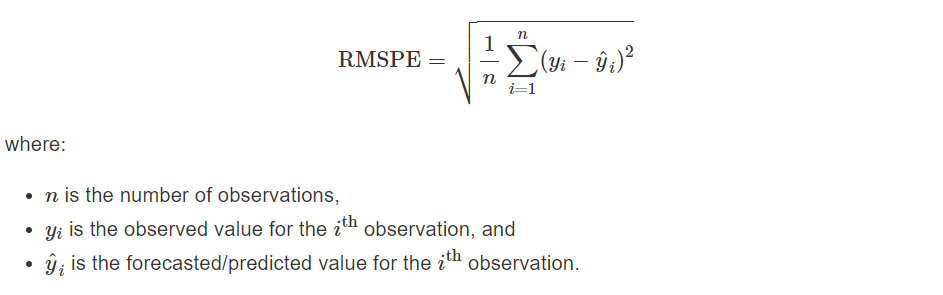

RMSE: Training Data  
RMPSE: Testing/Validation Data

**Cross Validation:**  

sacr_recipe <- recipe(price ~ sqft, data = sacramento_train) |>  
  step_scale(all_predictors()) |>  
  step_center(all_predictors())  

sacr_spec <- nearest_neighbor(weight_func = "rectangular",   
                              neighbors = tune()) |>  
  set_engine("kknn") |>  
  set_mode("regression")  

sacr_vfold <- vfold_cv(sacramento_train, v = 5, strata = price)  

sacr_wkflw <- workflow() |>  
  add_recipe(sacr_recipe) |>  
  add_model(sacr_spec)  

sacr_wkflw  

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))  

sacr_results <- sacr_wkflw |>  
  tune_grid(resamples = sacr_vfold, grid = gridvals) |>  
  collect_metrics() |>  
  filter(.metric == "rmse")  

sacr_results  

sacr_min <- sacr_results |>  
  filter(mean == min(mean))  

sacr_min  

**Prediction:**  

kmin <- sacr_min |> pull(neighbors)  

sacr_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>  
  set_engine("kknn") |>  
  set_mode("regression")  

sacr_fit <- workflow() |>  
  add_recipe(sacr_recipe) |>  
  add_model(sacr_spec) |>  
  fit(data = sacramento_train)  

sacr_summary <- sacr_fit |>  
  predict(sacramento_test) |>  
  bind_cols(sacramento_test) |>  
  metrics(truth = price, estimate = .pred) |>  
  filter(.metric == 'rmse')  

sacr_summary  

**Plotting Results:**  

sacr_preds <- tibble(sqft = seq(from = 500, to = 5000, by = 10))  

sacr_preds <- sacr_fit |>  
  predict(sacr_preds) |>  
  bind_cols(sacr_preds)  

plot_final <- ggplot(sacramento_train, aes(x = sqft, y = price)) +  
  geom_point(alpha = 0.4) +  
  geom_line(data = sacr_preds,   
            mapping = aes(x = sqft, y = .pred),   
            color = "blue") +  
  xlab("House size (square feet)") +  
  ylab("Price (USD)") +  
  scale_y_continuous(labels = dollar_format()) +  
  ggtitle(paste0("K = ", kmin)) +   
  theme(text = element_text(size = 12))  

plot_final  